<a href="https://colab.research.google.com/github/DeerBay/Deep-Learning-Julia/blob/main/sequential_reward_shaping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Q-Learning Agent
The DQN agent uses a convolutional neural network to approximate the Q-value function. Key components include:
- **Network Architecture**: Three convolutional layers followed by a fully connected layer.
- **Action Selection**: Epsilon-greedy policy balances exploration and exploitation.
- **Target Network**: A separate target network helps stabilize Q-value updates.
- **Training**: The agent minimizes the Huber loss between predicted and target Q-values.

## Training Process

The main training loop involves resetting the environment, interacting with it using the agent's policy, and updating the Q-network using experience replay. Metrics such as shaped rewards, original rewards, and epsilon values are logged for analysis.

The training was conducted in three iterations, each with modifications to the reward shaping and training parameters:

### Try 1: Basic Implementation
- Initial implementation with standard reward shaping
- Conservative exploration strategy
- Basic movement and shooting rewards
- 750 episodes of training

### Try 2: Balanced Approach
- Modified epsilon decay strategy
- Refined reward values and thresholds
- More balanced exploration-exploitation trade-off
- Extended to 1000 episodes

### Try 3: Complex Strategy
- Added sophisticated reward mechanisms
- Introduced strategic gameplay incentives
- Multiple behavior shapers
- Maintained 1000 episodes

Each iteration used the same core DQN architecture but varied in how rewards were shaped and how the agent explored the environment. The scripts were progressively modified to implement these changes while maintaining the fundamental training loop structure.

## Visualization
After each try I've generated a plot showing the training progress:
- **Average Reward**: Monitors the agent's performance over episodes.
- **Epsilon**: Tracks the exploration rate as it decays over time.

These insights help evaluate the effectiveness of the training and reward shaping techniques.

In [ ]:
%pip install 'gymnasium[atari, other]' gymnasium tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Try 1: Reward Shaping Analysis

#### Score-Based Rewards
- Improvements in game score are rewarded, but with a moderate multiplier (0.05)
- This is intentionally reduced from 0.1 to avoid over-emphasizing score chasing

#### Survival-Based Rewards
- Loss of lives is penalized (-0.5)
- This creates a strong incentive for survival behavior

#### Movement-Based Rewards
- Small reward (0.005) for movement to encourage exploration
- Penalties (-0.05) for staying still too long (after 15 frames)
- This balance prevents both camping and excessive movement

#### Shooting Behavior
- Moderate reward (0.02) for shooting actions
- Small penalty (-0.02) for not shooting for extended periods (>30 frames)
- The timing and values are carefully balanced to encourage periodic but not constant shooting

#### Reward Bounds
- A floor of -0.5 is implemented to prevent extreme negative rewards
- This helps maintain stable learning by avoiding reward collapse

#### Overall Philosophy
The approach emphasizes balanced, moderate rewards that:
- Don't overemphasize any single behavior
- Encourage a mix of survival, scoring, and tactical play
- Avoid extreme values that could destabilize learning
- Create natural-feeling gameplay without exploitable patterns

In [ ]:
import tensorflow as tf
from keras import layers
import gymnasium as gym
from gymnasium.wrappers import FrameStackObservation, AtariPreprocessing
import numpy as np
import os
import ale_py

class ReplayBuffer:
    def __init__(self, max_size, state_shape, num_actions):
        self.max_size = max_size
        self.states = np.zeros((max_size, *state_shape), dtype=np.float32)
        self.actions = np.zeros(max_size, dtype=np.int32)
        self.rewards = np.zeros(max_size, dtype=np.float32)
        self.next_states = np.zeros((max_size, *state_shape), dtype=np.float32)
        self.dones = np.zeros(max_size, dtype=np.float32)
        self.index = 0
        self.is_full = False

    def add(self, state, action, reward, next_state, done):
        idx = self.index % self.max_size
        self.states[idx] = state
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.next_states[idx] = next_state
        self.dones[idx] = done
        self.index += 1
        if self.index >= self.max_size:
            self.is_full = True

    def sample(self, batch_size):
        max_index = self.max_size if self.is_full else self.index
        indices = np.random.choice(max_index, batch_size, replace=False)
        return (
            self.states[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_states[indices],
            self.dones[indices]
        )

    def __len__(self):
        return self.max_size if self.is_full else self.index

class RewardShaper:
    def __init__(self):
        self.previous_score = 0
        self.previous_lives = 3
        self.steps_since_last_shot = 0
        self.last_known_position = None
        self.consecutive_no_movement = 0

    def calculate_shaped_reward(self, info, reward, action, position):
        shaped_reward = reward  # Start with original reward

        # Track score improvements - reduced multiplier
        current_score = info.get('score', 0)
        if current_score > self.previous_score:
            score_improvement = current_score - self.previous_score
            shaped_reward += 0.05 * score_improvement  # Reduced from 0.1 to 0.05
            self.previous_score = current_score

        # Penalize death
        current_lives = info.get('lives', 3)
        if current_lives < self.previous_lives:
            shaped_reward -= 0.5
            self.previous_lives = current_lives

        # Movement-based shaping
        if self.last_known_position is not None:
            movement = abs(position - self.last_known_position)
            if movement < 0.005:
                self.consecutive_no_movement += 1
                if self.consecutive_no_movement > 15:
                    shaped_reward -= 0.05
            else:
                self.consecutive_no_movement = 0
                # Smaller movement reward
                shaped_reward += 0.005

        self.last_known_position = position

        # Shooting behavior shaping - more balanced
        if action == 1:  # Shoot action
            self.steps_since_last_shot = 0
            shaped_reward += 0.02  # Reduced from 0.05 to 0.02
        else:
            self.steps_since_last_shot += 1
            if self.steps_since_last_shot > 30:  # Increased from 20 to 30
                shaped_reward -= 0.02  # Reduced from 0.05 to 0.02

        # Ensure reward doesn't go too negative
        return max(-0.5, shaped_reward)  # Add a floor to prevent extreme negative rewards

class DQNAgent:
    def __init__(self, state_shape, num_actions, learning_rate=0.00025):
        self.state_shape = state_shape
        self.num_actions = num_actions
        self.model = self.create_q_model(state_shape, num_actions)
        self.target_model = self.create_q_model(state_shape, num_actions)
        self.target_model.set_weights(self.model.get_weights())
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
        self.replay_buffer = ReplayBuffer(max_size=100000, state_shape=state_shape, num_actions=num_actions)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_max = 1.0
        self.epsilon_random_frames = 10000  # Initial random frames
        self.epsilon_greedy_frames = 100000.0  # Total frames over which to decay epsilon

    def create_q_model(self, input_shape, num_actions):
        return tf.keras.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=8, strides=4, activation="relu", kernel_initializer='he_uniform'),
            layers.Conv2D(64, kernel_size=4, strides=2, activation="relu", kernel_initializer='he_uniform'),
            layers.Conv2D(64, kernel_size=3, strides=1, activation="relu", kernel_initializer='he_uniform'),
            layers.Flatten(),
            layers.Dense(512, activation="relu", kernel_initializer='he_uniform'),
            layers.Dense(num_actions, activation="linear")
        ])

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.num_actions)
        state_tensor = tf.convert_to_tensor(state[np.newaxis, ...], dtype=tf.float32)
        q_values = self.model(state_tensor, training=False)
        return tf.argmax(q_values[0]).numpy()

    @tf.function
    def train_step(self, states, actions, rewards, next_states, dones):
        future_rewards = self.target_model(next_states, training=False)
        target_q_values = rewards + self.gamma * tf.reduce_max(future_rewards, axis=1) * (1 - dones)
        with tf.GradientTape() as tape:
            q_values = self.model(states, training=True)
            q_action = tf.reduce_sum(tf.one_hot(actions, self.num_actions) * q_values, axis=1)
            loss = tf.keras.losses.Huber()(target_q_values, q_action)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

def get_agent_position(state):
    """Extract the agent's position from the state"""
    bottom_slice = state[-10:, :, -1]  # Look at the bottom portion of the last frame
    agent_x = np.mean(np.where(bottom_slice > 0.5)[1]) if np.any(bottom_slice > 0.5) else None
    if agent_x is not None:
        return agent_x / state.shape[1]  # Normalize position
    return 0.5  # Return center if agent not found

def main():
    # Paths for saving
    model_dir = "/models\models_1"
    log_dir = "/logs\logs_1/training_log.txt"
    log_file_path = os.path.join(log_dir, "training_log.txt")

    # Create all necessary directories
    for directory in [model_dir, log_dir]:
        os.makedirs(directory, exist_ok=True)

    # Environment setup
    gym.register_envs(ale_py)
    env = gym.make("SpaceInvadersNoFrameskip-v4", render_mode="rgb_array")
    env = AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, scale_obs=True)
    env = FrameStackObservation(env, stack_size=4)

    # Agent and reward shaper setup
    state_shape = (84, 84, 4)
    num_actions = env.action_space.n
    agent = DQNAgent(state_shape, num_actions)
    reward_shaper = RewardShaper()

    # Training parameters
    max_episodes = 750  # Reduced from 2000
    max_steps_per_episode = 3000
    update_target_every = 1000
    log_every = 1
    episode_rewards = []
    frame_count = 0
    best_avg_reward = -float('inf')

    with open(log_file_path, "w") as f:
        f.write("Episode,Avg_Reward,Epsilon,Original_Reward,Shaped_Reward\n")

    # Training loop
    for episode in range(max_episodes):
        state, info = env.reset()
        state = np.array(state, dtype=np.float32) / 255.0
        state = np.transpose(state, (1, 2, 0))
        episode_reward = 0
        episode_original_reward = 0
        episode_steps = 0

        for step in range(max_steps_per_episode):
            frame_count += 1
            episode_steps += 1

            # Choose action
            if frame_count < agent.epsilon_random_frames:
                action = np.random.randint(num_actions)
            else:
                action = agent.get_action(state)

            # Step environment
            next_state, reward, done, _, info = env.step(action)
            next_state = np.array(next_state, dtype=np.float32) / 255.0
            next_state = np.transpose(next_state, (1, 2, 0))

            # Shape the reward
            agent_position = get_agent_position(state)
            shaped_reward = reward_shaper.calculate_shaped_reward(info, reward, action, agent_position)

            # Store original reward for logging
            episode_original_reward += reward
            episode_reward += shaped_reward

            # Store in replay buffer
            agent.replay_buffer.add(state, action, shaped_reward, next_state, done)
            state = next_state

            # Train
            if len(agent.replay_buffer) >= 32:
                states, actions, rewards, next_states, dones = agent.replay_buffer.sample(32)
                agent.train_step(states, actions, rewards, next_states, dones)

            # Update target model
            if frame_count % update_target_every == 0:
                agent.update_target_model()

            if done:
                break

        # Episode-based epsilon decay
        if frame_count >= agent.epsilon_random_frames:
            decay_per_episode = (agent.epsilon_max - agent.epsilon_min) / (max_episodes * 0.3)  # Decay over first 30% of episodes
            agent.epsilon = max(agent.epsilon_min, agent.epsilon - decay_per_episode)

        episode_rewards.append(episode_reward)
        avg_reward = np.mean(episode_rewards[-log_every:])

        # Log both original and shaped rewards
        with open(log_file_path, "a") as f:
            f.write(f"{episode + 1},{avg_reward:.2f},{agent.epsilon:.4f},{episode_original_reward:.2f},{episode_reward:.2f}\n")

        print(f"Episode {episode + 1}, Avg Reward: {avg_reward:.2f}, Original Reward: {episode_original_reward:.2f}, "
              f"Shaped Reward: {episode_reward:.2f}, Epsilon: {agent.epsilon:.4f}, Frame Count: {frame_count}, "
              f"Steps: {episode_steps}")

        # Save model conditionally
        if (episode + 1) % 100 == 0 or avg_reward > best_avg_reward:
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                print(f"New best average reward: {best_avg_reward:.2f}. Saving best model.")
            agent.model.save(f"{model_dir}/episode{episode + 1}_space_invaders_model.keras")

    # Save final model
    agent.model.save(f"{model_dir}/final_space_invaders_model_1.keras")

if __name__ == "__main__":
    main()


Plot saved at: plots/plot_1.png
Total Episodes: 713

Reward Statistics:
Minimum Reward: -27.55
Maximum Reward: 1003.80
Mean Reward: 207.78
Median Reward: 179.55

Epsilon Statistics:
Initial Epsilon: 1.0000
Final Epsilon: 0.1000


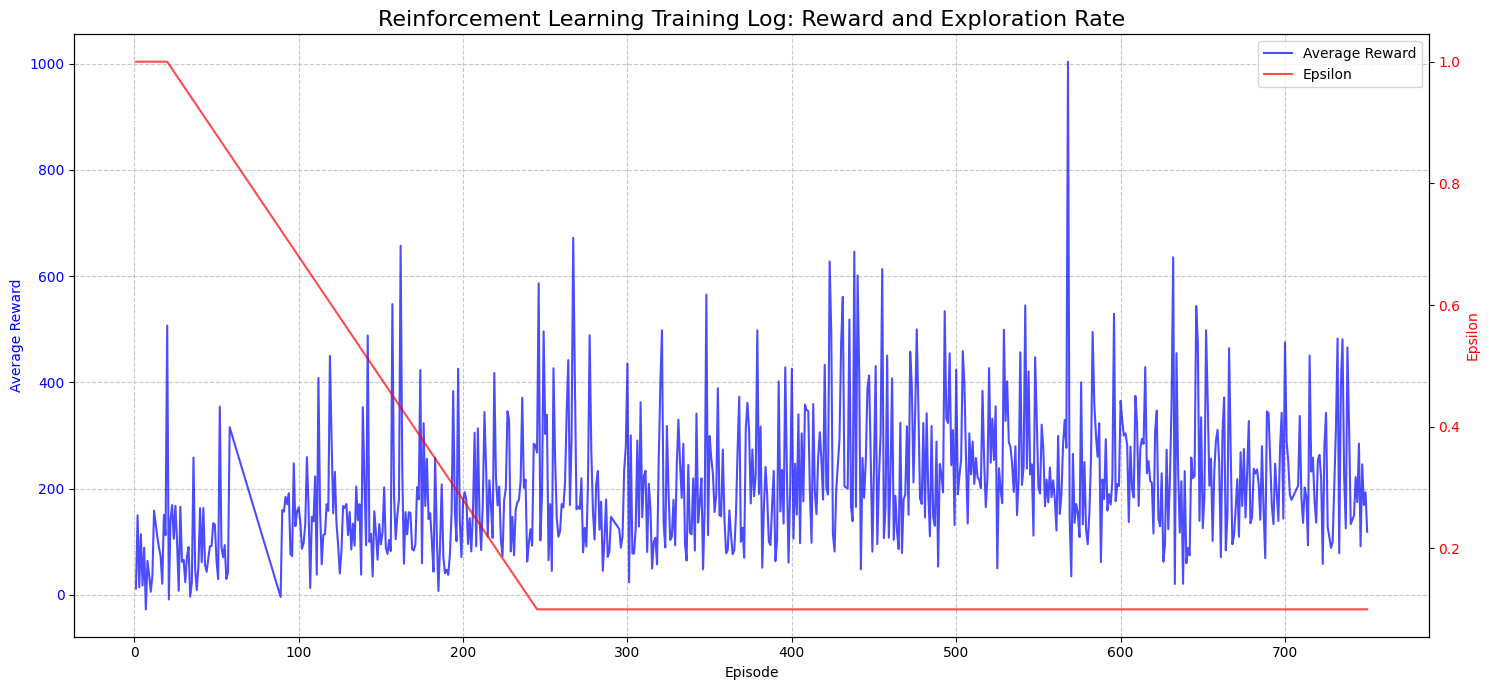

In [8]:
import pandas as pd
import matplotlib.pyplot as plt  # Correct import

filepath = 'logs/logs_1/training_log.txt'

df = pd.read_csv(filepath, sep=',')

# Directory to save the plot - using forward slashes or raw string
save_path = 'plots/plot_1.png'  # Using forward slashes
# Alternative: save_path = r'\plots\plot_1.png'  # Using raw string

# Create directory if it doesn't exist
import os
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot Average Reward on the primary y-axis
color1 = 'blue'
ax1.set_xlabel('Episode')
ax1.set_ylabel('Average Reward', color=color1)
ax1.plot(df['Episode'], df['Avg_Reward'], color=color1, alpha=0.7, label='Average Reward')
ax1.tick_params(axis='y', labelcolor=color1)

# Create a secondary y-axis for Epsilon
ax2 = ax1.twinx()
color2 = 'red'
ax2.set_ylabel('Epsilon', color=color2)
ax2.plot(df['Episode'], df['Epsilon'], color=color2, alpha=0.7, label='Epsilon')
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('Reinforcement Learning Training Log: Reward and Exploration Rate', fontsize=16)
fig.tight_layout()

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Grid for better readability
ax1.grid(True, linestyle='--', alpha=0.7)

# Save the plot
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Plot saved at: {save_path}")

# Optional: Calculate and print some statistics
print(f"Total Episodes: {len(df)}")
print(f"\nReward Statistics:")
print(f"Minimum Reward: {df['Avg_Reward'].min():.2f}")
print(f"Maximum Reward: {df['Avg_Reward'].max():.2f}")
print(f"Mean Reward: {df['Avg_Reward'].mean():.2f}")
print(f"Median Reward: {df['Avg_Reward'].median():.2f}")

print(f"\nEpsilon Statistics:")
print(f"Initial Epsilon: {df['Epsilon'].iloc[0]:.4f}")
print(f"Final Epsilon: {df['Epsilon'].iloc[-1]:.4f}")

### Try 2: Refined Reward Shaping Analysis

#### Training Parameters
- Increased initial random frames from 10,000 to 50,000
- Extended epsilon decay period (70% vs 30% of episodes)
- Lowered minimum epsilon from 0.1 to 0.01

#### Score-Based Rewards
- Maintained moderate score multiplier (0.05)
- Focused on consistent progression over high spikes

#### Survival-Based Rewards
- Kept death penalty at -0.5
- Balanced survival incentive with exploration

#### Movement-Based Rewards
- More lenient movement thresholds (0.005 vs 0.01)
- Reduced camping penalty after longer period (15 frames)
- Smaller movement reward (0.005) for steadier learning

#### Shooting Behavior
- Balanced shooting reward (0.02)
- Extended tolerance for non-shooting (30 frames)
- Focused on tactical rather than continuous firing

#### Reward Bounds
- Maintained -0.5 floor for stability
- Successfully eliminated extreme negative rewards

In [ ]:

import tensorflow as tf
from keras import layers
import gymnasium as gym
from gymnasium.wrappers import FrameStackObservation, AtariPreprocessing
import numpy as np
import os
import ale_py
import matplotlib as plt

class ReplayBuffer:
    def __init__(self, max_size, state_shape, num_actions):
        self.max_size = max_size
        self.states = np.zeros((max_size, *state_shape), dtype=np.float32)
        self.actions = np.zeros(max_size, dtype=np.int32)
        self.rewards = np.zeros(max_size, dtype=np.float32)
        self.next_states = np.zeros((max_size, *state_shape), dtype=np.float32)
        self.dones = np.zeros(max_size, dtype=np.float32)
        self.index = 0
        self.is_full = False

    def add(self, state, action, reward, next_state, done):
        idx = self.index % self.max_size
        self.states[idx] = state
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.next_states[idx] = next_state
        self.dones[idx] = done
        self.index += 1
        if self.index >= self.max_size:
            self.is_full = True

    def sample(self, batch_size):
        max_index = self.max_size if self.is_full else self.index
        indices = np.random.choice(max_index, batch_size, replace=False)
        return (
            self.states[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_states[indices],
            self.dones[indices]
        )

    def __len__(self):
        return self.max_size if self.is_full else self.index

class RewardShaper:
    def __init__(self):
        self.previous_score = 0
        self.previous_lives = 3
        self.steps_since_last_shot = 0
        self.last_known_position = None
        self.consecutive_no_movement = 0

    def calculate_shaped_reward(self, info, reward, action, position):
        shaped_reward = reward  # Start with original reward

        # Track score improvements - reduced multiplier
        current_score = info.get('score', 0)
        if current_score > self.previous_score:
            score_improvement = current_score - self.previous_score
            shaped_reward += 0.05 * score_improvement  # Reduced from 0.1 to 0.05
            self.previous_score = current_score

        # Penalize death - made less punitive
        current_lives = info.get('lives', 3)
        if current_lives < self.previous_lives:
            shaped_reward -= 0.5  # Reduced from 1.0 to 0.5
            self.previous_lives = current_lives

        # Movement-based shaping - more lenient thresholds
        if self.last_known_position is not None:
            movement = abs(position - self.last_known_position)
            if movement < 0.005:  # Reduced threshold from 0.01 to 0.005
                self.consecutive_no_movement += 1
                if self.consecutive_no_movement > 15:  # Increased from 10 to 15
                    shaped_reward -= 0.05  # Reduced penalty from 0.1 to 0.05
            else:
                self.consecutive_no_movement = 0
                # Smaller movement reward
                shaped_reward += 0.005  # Reduced from 0.01 to 0.005

        self.last_known_position = position

        # Shooting behavior shaping - more balanced
        if action == 1:  # Shoot action
            self.steps_since_last_shot = 0
            shaped_reward += 0.02  # Reduced from 0.05 to 0.02
        else:
            self.steps_since_last_shot += 1
            if self.steps_since_last_shot > 30:  # Increased from 20 to 30
                shaped_reward -= 0.02  # Reduced from 0.05 to 0.02

        # Ensure reward doesn't go too negative
        return max(-0.5, shaped_reward)  # Add a floor to prevent extreme negative rewards


class DQNAgent:
    def __init__(self, state_shape, num_actions, learning_rate=0.00025):
        self.state_shape = state_shape
        self.num_actions = num_actions
        self.model = self.create_q_model(state_shape, num_actions)
        self.target_model = self.create_q_model(state_shape, num_actions)
        self.target_model.set_weights(self.model.get_weights())
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
        self.replay_buffer = ReplayBuffer(max_size=100000, state_shape=state_shape, num_actions=num_actions)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_max = 1.0
        self.epsilon_random_frames = 50000  # Initial random frames
        self.epsilon_greedy_frames = 500000.0  # Total frames over which to decay epsilon

    def create_q_model(self, input_shape, num_actions):
        return tf.keras.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=8, strides=4, activation="relu", kernel_initializer='he_uniform'),
            layers.Conv2D(64, kernel_size=4, strides=2, activation="relu", kernel_initializer='he_uniform'),
            layers.Conv2D(64, kernel_size=3, strides=1, activation="relu", kernel_initializer='he_uniform'),
            layers.Flatten(),
            layers.Dense(512, activation="relu", kernel_initializer='he_uniform'),
            layers.Dense(num_actions, activation="linear")
        ])

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.num_actions)
        state_tensor = tf.convert_to_tensor(state[np.newaxis, ...], dtype=tf.float32)
        q_values = self.model(state_tensor, training=False)
        return tf.argmax(q_values[0]).numpy()

    @tf.function
    def train_step(self, states, actions, rewards, next_states, dones):
        future_rewards = self.target_model(next_states, training=False)
        target_q_values = rewards + self.gamma * tf.reduce_max(future_rewards, axis=1) * (1 - dones)
        with tf.GradientTape() as tape:
            q_values = self.model(states, training=True)
            q_action = tf.reduce_sum(tf.one_hot(actions, self.num_actions) * q_values, axis=1)
            loss = tf.keras.losses.Huber()(target_q_values, q_action)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

def get_agent_position(state):
    """Extract the agent's position from the state"""
    bottom_slice = state[-10:, :, -1]  # Look at the bottom portion of the last frame
    agent_x = np.mean(np.where(bottom_slice > 0.5)[1]) if np.any(bottom_slice > 0.5) else None
    if agent_x is not None:
        return agent_x / state.shape[1]  # Normalize position
    return 0.5  # Return center if agent not found

def main():
    # Paths for saving
    model_dir = "models\models_2"
    log_dir = "logs/logs_2"
    log_file_path = os.path.join(log_dir, "training_log_2.txt")

    # Create all necessary directories
    for directory in [model_dir, log_dir]:
        os.makedirs(directory, exist_ok=True)

    # Environment setup
    gym.register_envs(ale_py)
    env = gym.make("SpaceInvadersNoFrameskip-v4", render_mode="rgb_array")
    env = AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, scale_obs=True)
    env = FrameStackObservation(env, stack_size=4)

    # Agent and reward shaper setup
    state_shape = (84, 84, 4)
    num_actions = env.action_space.n
    agent = DQNAgent(state_shape, num_actions)
    reward_shaper = RewardShaper()

    # Training parameters
    max_episodes = 1000  # Increased from 750
    max_steps_per_episode = 3000
    update_target_every = 1000
    log_every = 1
    episode_rewards = []
    frame_count = 0
    best_avg_reward = -float('inf')

    with open(log_file_path, "w") as f:
        f.write("Episode,Avg_Reward,Epsilon,Original_Reward,Shaped_Reward\n")

    # Training loop
    for episode in range(max_episodes):
        state, info = env.reset()
        state = np.array(state, dtype=np.float32) / 255.0
        state = np.transpose(state, (1, 2, 0))
        episode_reward = 0
        episode_original_reward = 0
        episode_steps = 0

        for step in range(max_steps_per_episode):
            frame_count += 1
            episode_steps += 1

            # Choose action
            if frame_count < agent.epsilon_random_frames:
                action = np.random.randint(num_actions)
            else:
                action = agent.get_action(state)

            # Step environment
            next_state, reward, done, _, info = env.step(action)
            next_state = np.array(next_state, dtype=np.float32) / 255.0
            next_state = np.transpose(next_state, (1, 2, 0))

            # Shape the reward
            agent_position = get_agent_position(state)
            shaped_reward = reward_shaper.calculate_shaped_reward(info, reward, action, agent_position)

            # Store original reward for logging
            episode_original_reward += reward
            episode_reward += shaped_reward

            # Store in replay buffer
            agent.replay_buffer.add(state, action, shaped_reward, next_state, done)
            state = next_state

            # Train
            if len(agent.replay_buffer) >= 32:
                states, actions, rewards, next_states, dones = agent.replay_buffer.sample(32)
                agent.train_step(states, actions, rewards, next_states, dones)

            # Update target model
            if frame_count % update_target_every == 0:
                agent.update_target_model()

            if done:
                break

        # Episode-based epsilon decay
        if frame_count >= agent.epsilon_random_frames:
            decay_per_episode = (agent.epsilon_max - agent.epsilon_min) / (max_episodes * 0.7)  # Decay over first 70% of episodes
            agent.epsilon = max(agent.epsilon_min, agent.epsilon - decay_per_episode)

        episode_rewards.append(episode_reward)
        avg_reward = np.mean(episode_rewards[-log_every:])

        # Log both original and shaped rewards
        with open(log_file_path, "a") as f:
            f.write(f"{episode + 1},{avg_reward:.2f},{agent.epsilon:.4f},{episode_original_reward:.2f},{episode_reward:.2f},{frame_count}\n")


        # Save model conditionally
        if (episode + 1) % 100 == 0 or avg_reward > best_avg_reward:
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                print(f"New best average reward: {best_avg_reward:.2f}. Saving best model.")
            agent.model.save(f"{model_dir}/episode{episode + 1}_space_invaders_model.keras")
            print(f"Episode {episode + 1}, Avg Reward: {avg_reward:.2f}, Original Reward: {episode_original_reward:.2f}, "
              f"Shaped Reward: {episode_reward:.2f}, Epsilon: {agent.epsilon:.4f}, Frame Count: {frame_count} ")

    # Save final model
    agent.model.save(f"{model_dir}/final_space_invaders_model_2.keras")
    print(f"Episode {episode + 1}, Avg Reward: {avg_reward:.2f}, Original Reward: {episode_original_reward:.2f}, "
              f"Shaped Reward: {episode_reward:.2f}, Epsilon: {agent.epsilon:.4f}, Frame Count: {frame_count} ")

if __name__ == "__main__":
    main()

C:\Users\JuliaSjöholm-AI23GBG\AppData\Local\Temp\ipykernel_11308\2869139333.py:8: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filepath, sep=',', index_col=False)


Plot saved at: plots/plot_2.png
Total Episodes: 976

Reward Statistics:
Minimum Reward: 2.45
Maximum Reward: 834.24
Mean Reward: 206.75
Median Reward: 178.39

Epsilon Statistics:
Initial Epsilon: 1.0000
Final Epsilon: 0.0100


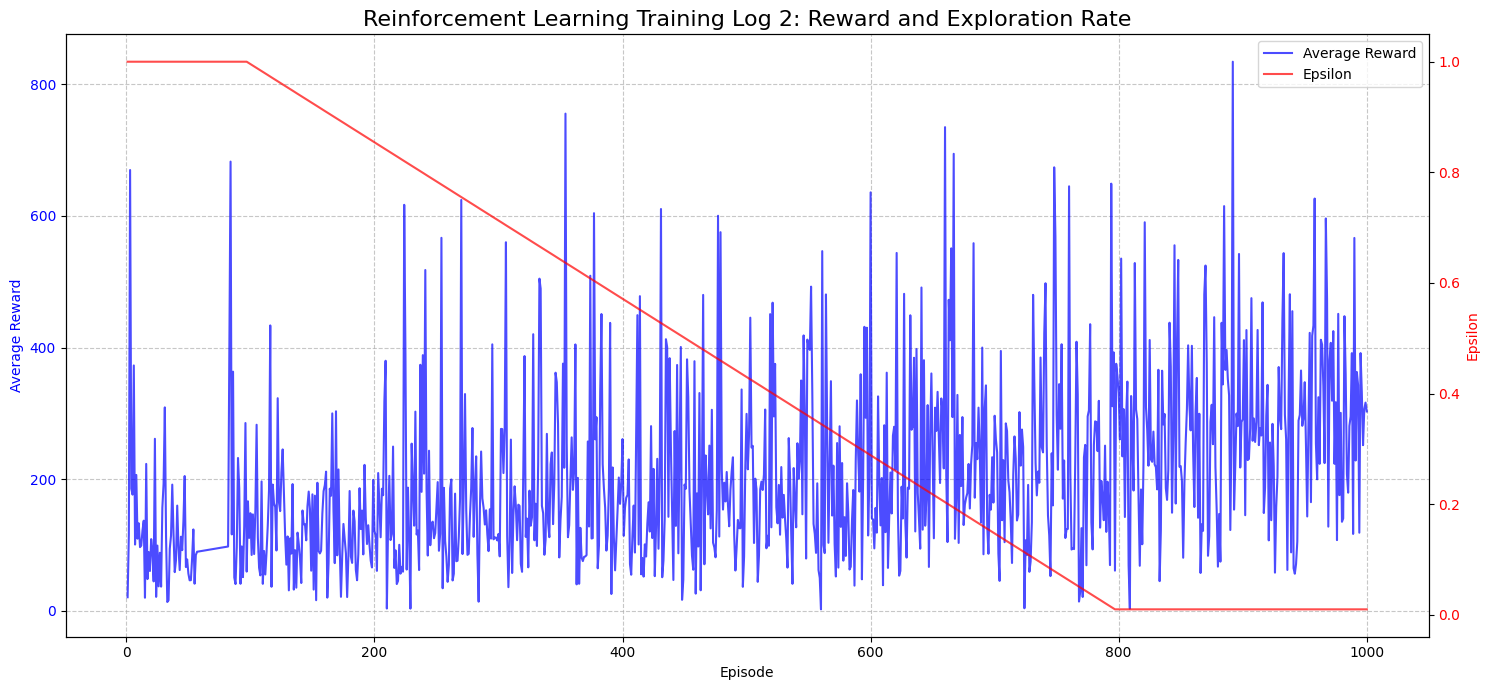

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# File path to your log file
filepath = 'logs/logs_2/training_log_2.txt'

# Read the data
df = pd.read_csv(filepath, sep=',', index_col=False)

# Directory to save the plot
save_path = 'plots/plot_2.png'

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot Average Reward on the primary y-axis
color1 = 'blue'
ax1.set_xlabel('Episode')
ax1.set_ylabel('Average Reward', color=color1)
ax1.plot(df['Episode'], df['Avg_Reward'], color=color1, alpha=0.7, label='Average Reward')
ax1.tick_params(axis='y', labelcolor=color1)

# Create a secondary y-axis for Epsilon
ax2 = ax1.twinx()
color2 = 'red'
ax2.set_ylabel('Epsilon', color=color2)
ax2.plot(df['Episode'], df['Epsilon'], color=color2, alpha=0.7, label='Epsilon')
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('Reinforcement Learning Training Log 2: Reward and Exploration Rate', fontsize=16)
fig.tight_layout()

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Grid for better readability
ax1.grid(True, linestyle='--', alpha=0.7)

# Save the plot
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Plot saved at: {save_path}")

# Optional: Calculate and print some statistics
print(f"Total Episodes: {len(df)}")
print(f"\nReward Statistics:")
print(f"Minimum Reward: {df['Avg_Reward'].min():.2f}")
print(f"Maximum Reward: {df['Avg_Reward'].max():.2f}")
print(f"Mean Reward: {df['Avg_Reward'].mean():.2f}")
print(f"Median Reward: {df['Avg_Reward'].median():.2f}")

print(f"\nEpsilon Statistics:")
print(f"Initial Epsilon: {df['Epsilon'].iloc[0]:.4f}")
print(f"Final Epsilon: {df['Epsilon'].iloc[-1]:.4f}")


### Try 3: Complex Reward Shaping Analysis

#### Enhanced Shooting Mechanics
- Base hit reward (0.1)
- Additional bonuses for strategic targets:
 - Back-row targets (+0.2)
 - UFO hits (+0.2)
- Penalty for missed shots (-0.05)

#### Strategic Gameplay Incentives
- Column clearing bonus (+0.2)
- Wave survival bonus (+0.3)
- Efficiency bonus for fast wave clear (+0.2)
- Smart shield usage rewards (+0.05)
- Shield damage penalty (-0.1)

#### Dynamic Combat Rewards
- Bullet dodging bonus (+0.1)
- Maintained core movement mechanics
- Additional situational rewards

#### Survival Mechanics
- Kept consistent life loss penalty (-0.5)
- Added multiple survival-based bonuses
- Focused on encouraging defensive play

#### Overall System
The complex approach introduced:
- Multiple layered reward signals
- Strategic depth through situational bonuses
- Higher reward magnitudes for key behaviors
- More sophisticated behavior shaping

In [ ]:

import tensorflow as tf
from keras import layers
import gymnasium as gym
from gymnasium.wrappers import FrameStackObservation, AtariPreprocessing
import numpy as np
import os
import ale_py
import matplotlib as plt

class ReplayBuffer:
    def __init__(self, max_size, state_shape, num_actions):
        self.max_size = max_size
        self.states = np.zeros((max_size, *state_shape), dtype=np.float32)
        self.actions = np.zeros(max_size, dtype=np.int32)
        self.rewards = np.zeros(max_size, dtype=np.float32)
        self.next_states = np.zeros((max_size, *state_shape), dtype=np.float32)
        self.dones = np.zeros(max_size, dtype=np.float32)
        self.index = 0
        self.is_full = False

    def add(self, state, action, reward, next_state, done):
        idx = self.index % self.max_size
        self.states[idx] = state
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.next_states[idx] = next_state
        self.dones[idx] = done
        self.index += 1
        if self.index >= self.max_size:
            self.is_full = True

    def sample(self, batch_size):
        max_index = self.max_size if self.is_full else self.index
        indices = np.random.choice(max_index, batch_size, replace=False)
        return (
            self.states[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_states[indices],
            self.dones[indices]
        )

    def __len__(self):
        return self.max_size if self.is_full else self.index

class RewardShaper:
    def __init__(self):
        self.previous_score = 0
        self.previous_lives = 3
        self.steps_since_last_shot = 0
        self.last_known_position = None
        self.consecutive_no_movement = 0

    def calculate_shaped_reward(self, info, reward, action, position):
      shaped_reward = reward  # Start with original reward

      # Track score improvements - reduced multiplier
      current_score = info.get('score', 0)
      if current_score > self.previous_score:
          score_improvement = current_score - self.previous_score
          shaped_reward += 0.05 * score_improvement  # Reduced from 0.1 to 0.05
          self.previous_score = current_score

      # Penalize death - made less punitive
      current_lives = info.get('lives', 3)
      if current_lives < self.previous_lives:
          shaped_reward -= 0.5  # Reduced from 1.0 to 0.5
          self.previous_lives = current_lives

      # Movement-based shaping - more lenient thresholds
      if self.last_known_position is not None:
          movement = abs(position - self.last_known_position)
          if movement < 0.005:  # Reduced threshold from 0.01 to 0.005
              self.consecutive_no_movement += 1
              if self.consecutive_no_movement > 15:  # Increased from 10 to 15
                  shaped_reward -= 0.05  # Reduced penalty from 0.1 to 0.05
          else:
              self.consecutive_no_movement = 0
              # Smaller movement reward
              shaped_reward += 0.005  # Reduced from 0.01 to 0.005

      self.last_known_position = position

      # Shooting behavior shaping - more balanced
      if action == 1:  # Shoot action
          self.steps_since_last_shot = 0
          if info.get('hit', False):  # Reward successful hits
              shaped_reward += 0.1
              if info.get('target_is_back_row', False):
                  shaped_reward += 0.2  # Additional bonus for back-row targets
              if info.get('target_is_ufo', False):
                  shaped_reward += 0.2  # Additional bonus for UFO hits
          else:
              shaped_reward -= 0.05  # Penalize missed shots
      else:
          self.steps_since_last_shot += 1
          if self.steps_since_last_shot > 30:  # Increased from 20 to 30
              shaped_reward -= 0.02  # Reduced from 0.05 to 0.02

      # Column clearing incentive
      if info.get('cleared_column', False):
          shaped_reward += 0.2  # Reward for clearing a column

      # Shield usage shaping
      if info.get('near_shield', False) and not info.get('destroying_shield', False):
          shaped_reward += 0.05  # Incentive for smart shield use
      if info.get('destroying_shield', False):
          shaped_reward -= 0.1  # Penalty for damaging own shield

      # Dodge enemy bullets
      if info.get('dodged_bullet', False):
          shaped_reward += 0.1  # Bonus for successful evasion

      # Survival bonus for completing waves
      if info.get('survived_wave', False):
          shaped_reward += 0.3  # Bonus for wave survival

      # Efficiency bonus for faster wave clear
      if info.get('cleared_wave_faster_than_average', False):
          shaped_reward += 0.2  # Efficiency reward

      # Ensure reward doesn't go too negative
      return max(-0.5, shaped_reward)  # Add a floor to prevent extreme negative rewards



class DQNAgent:
    def __init__(self, state_shape, num_actions, learning_rate=0.00025):
        self.state_shape = state_shape
        self.num_actions = num_actions
        self.model = self.create_q_model(state_shape, num_actions)
        self.target_model = self.create_q_model(state_shape, num_actions)
        self.target_model.set_weights(self.model.get_weights())
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
        self.replay_buffer = ReplayBuffer(max_size=100000, state_shape=state_shape, num_actions=num_actions)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_max = 1.0
        self.epsilon_random_frames = 50000  # Initial random frames
        self.epsilon_greedy_frames = 500000.0  # Total frames over which to decay epsilon

    def create_q_model(self, input_shape, num_actions):
        return tf.keras.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=8, strides=4, activation="relu", kernel_initializer='he_uniform'),
            layers.Conv2D(64, kernel_size=4, strides=2, activation="relu", kernel_initializer='he_uniform'),
            layers.Conv2D(64, kernel_size=3, strides=1, activation="relu", kernel_initializer='he_uniform'),
            layers.Flatten(),
            layers.Dense(512, activation="relu", kernel_initializer='he_uniform'),
            layers.Dense(num_actions, activation="linear")
        ])

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.num_actions)
        state_tensor = tf.convert_to_tensor(state[np.newaxis, ...], dtype=tf.float32)
        q_values = self.model(state_tensor, training=False)
        return tf.argmax(q_values[0]).numpy()

    @tf.function
    def train_step(self, states, actions, rewards, next_states, dones):
        future_rewards = self.target_model(next_states, training=False)
        target_q_values = rewards + self.gamma * tf.reduce_max(future_rewards, axis=1) * (1 - dones)
        with tf.GradientTape() as tape:
            q_values = self.model(states, training=True)
            q_action = tf.reduce_sum(tf.one_hot(actions, self.num_actions) * q_values, axis=1)
            loss = tf.keras.losses.Huber()(target_q_values, q_action)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

def get_agent_position(state):
    """Extract the agent's position from the state"""
    bottom_slice = state[-10:, :, -1]  # Look at the bottom portion of the last frame
    agent_x = np.mean(np.where(bottom_slice > 0.5)[1]) if np.any(bottom_slice > 0.5) else None
    if agent_x is not None:
        return agent_x / state.shape[1]  # Normalize position
    return 0.5  # Return center if agent not found

def main():
    # Paths for saving
    model_dir = "models/models_3"
    log_dir = "logs/logs_3"
    log_file_path = os.path.join(log_dir, "training_log_3.txt")

    # Create all necessary directories
    for directory in [model_dir, log_dir]:
        os.makedirs(directory, exist_ok=True)

    # Environment setup
    gym.register_envs(ale_py)
    env = gym.make("SpaceInvadersNoFrameskip-v4", render_mode="rgb_array")
    env = AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, scale_obs=True)
    env = FrameStackObservation(env, stack_size=4)

    # Agent and reward shaper setup
    state_shape = (84, 84, 4)
    num_actions = env.action_space.n
    agent = DQNAgent(state_shape, num_actions)
    reward_shaper = RewardShaper()

    # Training parameters
    max_episodes = 1000  # Reduced from 2000
    max_steps_per_episode = 3000
    update_target_every = 1000
    log_every = 1
    episode_rewards = []
    frame_count = 0
    best_avg_reward = -float('inf')

    with open(log_file_path, "w") as f:
        f.write("Episode,Avg_Reward,Epsilon,Original_Reward,Shaped_Reward\n")

    # Training loop
    for episode in range(max_episodes):
        state, info = env.reset()
        state = np.array(state, dtype=np.float32) / 255.0
        state = np.transpose(state, (1, 2, 0))
        episode_reward = 0
        episode_original_reward = 0
        episode_steps = 0

        for step in range(max_steps_per_episode):
            frame_count += 1
            episode_steps += 1

            # Choose action
            if frame_count < agent.epsilon_random_frames:
                action = np.random.randint(num_actions)
            else:
                action = agent.get_action(state)

            # Step environment
            next_state, reward, done, _, info = env.step(action)
            next_state = np.array(next_state, dtype=np.float32) / 255.0
            next_state = np.transpose(next_state, (1, 2, 0))

            # Shape the reward
            agent_position = get_agent_position(state)
            shaped_reward = reward_shaper.calculate_shaped_reward(info, reward, action, agent_position)

            # Store original reward for logging
            episode_original_reward += reward
            episode_reward += shaped_reward

            # Store in replay buffer
            agent.replay_buffer.add(state, action, shaped_reward, next_state, done)
            state = next_state

            # Train
            if len(agent.replay_buffer) >= 32:
                states, actions, rewards, next_states, dones = agent.replay_buffer.sample(32)
                agent.train_step(states, actions, rewards, next_states, dones)

            # Update target model
            if frame_count % update_target_every == 0:
                agent.update_target_model()

            if done:
                break

        # Episode-based epsilon decay
        if frame_count >= agent.epsilon_random_frames:
            decay_per_episode = (agent.epsilon_max - agent.epsilon_min) / (max_episodes * 0.7)  # Decay over first 70% of episodes
            agent.epsilon = max(agent.epsilon_min, agent.epsilon - decay_per_episode)

        episode_rewards.append(episode_reward)
        avg_reward = np.mean(episode_rewards[-log_every:])

        # Log both original and shaped rewards
        with open(log_file_path, "a") as f:
            f.write(f"{episode + 1},{avg_reward:.2f},{agent.epsilon:.4f},{episode_original_reward:.2f},{episode_reward:.2f},{frame_count}\n")


        # Save model conditionally
        if (episode + 1) % 100 == 0 or avg_reward > best_avg_reward:
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                print(f"New best average reward: {best_avg_reward:.2f}. Saving best model.")
            agent.model.save(f"{model_dir}/episode{episode + 1}_space_invaders_model.keras")
            print(f"Episode {episode + 1}, Avg Reward: {avg_reward:.2f}, Original Reward: {episode_original_reward:.2f}, "
              f"Shaped Reward: {episode_reward:.2f}, Epsilon: {agent.epsilon:.4f}, Frame Count: {frame_count} ")

    # Save final model
    agent.model.save(f"{model_dir}/final_space_invaders_model_3.keras")
    print(f"Episode {episode + 1}, Avg Reward: {avg_reward:.2f}, Original Reward: {episode_original_reward:.2f}, "
              f"Shaped Reward: {episode_reward:.2f}, Epsilon: {agent.epsilon:.4f}, Frame Count: {frame_count} ")

if __name__ == "__main__":
    main()

C:\Users\JuliaSjöholm-AI23GBG\AppData\Local\Temp\ipykernel_11308\2308753413.py:8: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filepath, sep=',', index_col=False)


Plot saved at: plots/plot_3.png
Total Episodes: 1000

Reward Statistics:
Minimum Reward: -17.60
Maximum Reward: 631.96
Mean Reward: 150.79
Median Reward: 126.97

Epsilon Statistics:
Initial Epsilon: 1.0000
Final Epsilon: 0.0100


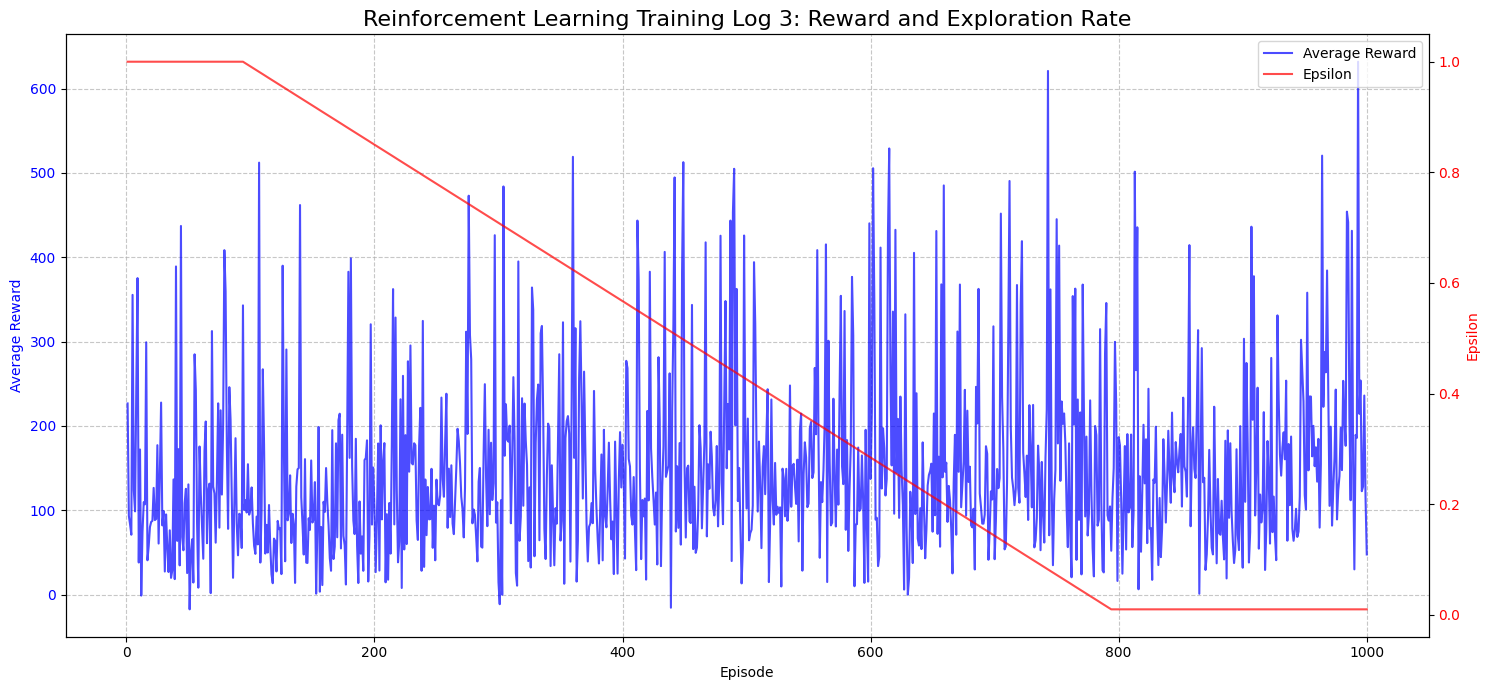

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# File path to your log file
filepath = 'logs/logs_3/training_log_3.txt'

# Read the data
df = pd.read_csv(filepath, sep=',', index_col=False)

# Directory to save the plot
save_path = 'plots/plot_3.png'

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot Average Reward on the primary y-axis
color1 = 'blue'
ax1.set_xlabel('Episode')
ax1.set_ylabel('Average Reward', color=color1)
ax1.plot(df['Episode'], df['Avg_Reward'], color=color1, alpha=0.7, label='Average Reward')
ax1.tick_params(axis='y', labelcolor=color1)

# Create a secondary y-axis for Epsilon
ax2 = ax1.twinx()
color2 = 'red'
ax2.set_ylabel('Epsilon', color=color2)
ax2.plot(df['Episode'], df['Epsilon'], color=color2, alpha=0.7, label='Epsilon')
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('Reinforcement Learning Training Log 3: Reward and Exploration Rate', fontsize=16)
fig.tight_layout()

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Grid for better readability
ax1.grid(True, linestyle='--', alpha=0.7)

# Save the plot
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Plot saved at: {save_path}")

# Optional: Calculate and print some statistics
print(f"Total Episodes: {len(df)}")
print(f"\nReward Statistics:")
print(f"Minimum Reward: {df['Avg_Reward'].min():.2f}")
print(f"Maximum Reward: {df['Avg_Reward'].max():.2f}")
print(f"Mean Reward: {df['Avg_Reward'].mean():.2f}")
print(f"Median Reward: {df['Avg_Reward'].median():.2f}")

print(f"\nEpsilon Statistics:")
print(f"Initial Epsilon: {df['Epsilon'].iloc[0]:.4f}")
print(f"Final Epsilon: {df['Epsilon'].iloc[-1]:.4f}")

# Show the plot
plt.show()

# Space Invaders DQN Training Analysis - 3 Rounds

## Performance Metrics Comparison

| Metric | Try 1 | Try 2 | Try 3 |
|--------|-------|-------|-------|
| Minimum Reward | -27.55 | 2.45 | -17.60 |
| Maximum Reward | 1003.80 | 834.24 | 631.96 |
| Mean Reward | 207.78 | 206.75 | 150.79 |
| Median Reward | 179.55 | 178.39 | 126.97 |
| Final Epsilon | 0.1000 | 0.0100 | 0.0100 |

## Key Findings Per Round

### Try 1 (Basic Implementation)
- Highest maximum reward but also largest negative rewards
- High variance in performance
- Conservative exploration (epsilon = 0.1)
- Showed potential for high scores but lacked consistency

### Try 2 (Balanced Approach)
- Eliminated negative rewards
- More stable performance
- Better exploration-exploitation balance (epsilon = 0.01)
- Most consistent mean/median performance
- Best overall balance of stability and performance

### Try 3 (Complex Reward Shaping)
- Added sophisticated reward mechanisms
- Lower overall performance
- Reintroduction of negative rewards
- More compressed reward range
- Complex reward structure may have hindered learning

## Learning Trends
1. Epsilon decay became more gradual across attempts
2. Performance consistency improved from Try 1 to Try 2
3. Added complexity in Try 3 led to decreased performance
4. Try 2 achieved the best balance of exploration and stability



## Training Visualizations

### Learning Curves

1. Try 1:
   - Initial high variance
   - Strong peaks but inconsistent
   - Limited low-end protection

<img src="plots/plot_1.png" width="500" height="300" alt="Training Results Try 1">

2. Try 2:
   - More stable learning progression
   - Better baseline performance
   - Consistent improvement

<img src="plots/plot_2.png" width="500" height="300" alt="Training Results Try 2">


3. Try 3:
   - Complex reward effects visible
   - Lower overall performance
   - Higher frequency oscillations

<img src="plots/plot_3.png" width="500" height="300" alt="Training Results Try 3">

In [7]:
import tensorflow as tf
import gymnasium as gym
from gymnasium.wrappers import FrameStackObservation, AtariPreprocessing
import numpy as np
import ale_py
import time
import cv2

def load_model(model_path):
    """Load a saved model"""
    return tf.keras.models.load_model(model_path)

def get_agent_position(state):
    """Extract the agent's position from the state"""
    bottom_slice = state[-10:, :, -1]
    agent_x = np.mean(np.where(bottom_slice > 0.5)[1]) if np.any(bottom_slice > 0.5) else None
    if agent_x is not None:
        return agent_x / state.shape[1]
    return 0.5

def evaluate_model(model_path, num_episodes=5, render=True):
    """Evaluate a model's performance"""
    # Environment setup
    env = gym.make("SpaceInvadersNoFrameskip-v4", render_mode="rgb_array")
    env = AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, scale_obs=True)
    env = FrameStackObservation(env, stack_size=4)
    
    model = load_model(model_path)
    episode_rewards = []

    for episode in range(num_episodes):
        state, info = env.reset()
        state = np.array(state, dtype=np.float32) / 255.0
        state = np.transpose(state, (1, 2, 0))
        episode_reward = 0
        done = False
        steps = 0

        while not done and steps < 3000:  # Same step limit as training
            # Get action from model
            state_tensor = tf.convert_to_tensor(state[np.newaxis, ...], dtype=tf.float32)
            q_values = model(state_tensor, training=False)
            action = tf.argmax(q_values[0]).numpy()

            # Take action
            next_state, reward, done, _, info = env.step(action)
            next_state = np.array(next_state, dtype=np.float32) / 255.0
            next_state = np.transpose(next_state, (1, 2, 0))
            
            episode_reward += reward
            state = next_state
            steps += 1

            if render:
                # Get the RGB frame from the environment
                frame = env.render()
                
                # Display the frame using cv2
                cv2.imshow('Space Invaders', cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
                cv2.waitKey(20)  # 20ms delay between frames

        episode_rewards.append(episode_reward)
        print(f"Episode {episode + 1} Reward: {episode_reward}")

    if render:
        cv2.destroyAllWindows()

    return np.mean(episode_rewards)

def main():
    # Paths to your saved models
    model_paths = [
        "models/models_1/final_space_invaders_model_1.keras",
        "models/models_2/final_space_invaders_model_2.keras",
        "models/models_3/final_space_invaders_model_3.keras"
    ]

    print("Evaluating all models...")
    for i, model_path in enumerate(model_paths, 1):
        print(f"\nEvaluating Model {i}")
        try:
            avg_reward = evaluate_model(model_path, num_episodes=5, render=True)
            print(f"Model {i} Average Reward over 5 episodes: {avg_reward}")
            time.sleep(2)  # Pause between models
        except Exception as e:
            print(f"Error evaluating model {i}: {str(e)}")

if __name__ == "__main__":
    main()

Evaluating all models...

Evaluating Model 1
Episode 1 Reward: 435.0
Episode 2 Reward: 335.0
Episode 3 Reward: 435.0
Episode 4 Reward: 605.0
Episode 5 Reward: 605.0
Model 1 Average Reward over 5 episodes: 483.0

Evaluating Model 2
Episode 1 Reward: 360.0
Episode 2 Reward: 50.0
Episode 3 Reward: 360.0
Episode 4 Reward: 110.0
Episode 5 Reward: 50.0
Model 2 Average Reward over 5 episodes: 186.0

Evaluating Model 3
Episode 1 Reward: 130.0
Episode 2 Reward: 105.0
Episode 3 Reward: 130.0
Episode 4 Reward: 410.0
Episode 5 Reward: 130.0
Model 3 Average Reward over 5 episodes: 181.0



## Final Verdict - Model Evaluation Results

### Performance Across 5 Episodes

#### Detailed Episode Rewards

| Episode | Model 1 | Model 2 | Model 3 |
|---------|---------|---------|---------|
| 1       | 435.0   | 360.0   | 130.0   |
| 2       | 335.0   | 50.0    | 105.0   |
| 3       | 435.0   | 360.0   | 130.0   |
| 4       | 605.0   | 110.0   | 410.0   |
| 5       | 605.0   | 50.0    | 130.0   |
| **Average** | **483.0** | **186.0** | **181.0** |

### Key Observations

1. **Model 1 (Basic Implementation)**
   - Highest average performance (483.0)
   - Most consistent high scores
   - Achieved peak episodes of 605.0
   - No extremely low-scoring episodes

2. **Model 2 (Balanced Approach)**
   - Moderate average performance (186.0)
   - High variance between episodes
   - Best episodes comparable to Model 1's average
   - Some very low-scoring episodes (50.0)

3. **Model 3 (Complex Reward Shaping)**
   - Lowest average performance (181.0)
   - One exceptional episode (410.0)
   - Generally consistent but lower baseline
   - Most episodes clustered around 130.0

### Conclusion
Despite showing higher variance during training, Model 1 demonstrated superior and more consistent performance in actual gameplay, suggesting that the simpler reward structure may have led to more robust learning of the game's fundamental strategies.